### Grad-CAM implementation for multi-label VGG16 and Inception v3
(depends on MonaLIA package)

https://arxiv.org/abs/1610.02391

https://github.com/jacobgil/pytorch-grad-cam

https://medium.com/@mohamedchetoui/grad-cam-gradient-weighted-class-activation-mapping-ffd72742243a


In [1]:
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
from torchvision import datasets


import matplotlib.cm as colormap
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import copy

import sys
import os

import numpy as np
import pandas as pd

from IPython.display import display, HTML

In [2]:
import importlib 

# Import MonaLIA library from the package in the subfolder of the notebook folder
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import MonaLIA.model.grad_cam as grad_cam
importlib.reload(grad_cam)

import MonaLIA.util.visualization_helpers as viz
importlib.reload(viz)

from MonaLIA.model.grad_cam import GradCAM_Inception, GradCAM_VGG, run_gradCAM

from MonaLIA.data.image_dataset import JocondeDataset
from MonaLIA.data.binary_subset import BinarySubset

from MonaLIA.util.visualization_helpers import gather_annotation_target, image_tensor_to_np
from MonaLIA.util.visualization_helpers import get_thumbnail, image_base64, image_formatter, label_formatter

In [3]:
print('PyTorch ver.' ,  torch.__version__ )
print('torchvision ver.' ,  torchvision.__version__ )
print('cuda ver.', torch.version.cuda)
print('pandas ver.', pd.__version__)

PyTorch ver. 1.6.0
torchvision ver. 0.7.0
cuda ver. 10.2
pandas ver. 1.1.1


### Load Model

In [21]:
checkpoint_file = 'pth\\inception_v3_Joconde_40_classes.1000.no_sched.checkpoint.pth.tar'
checkpoint = torch.load(checkpoint_file)
classes = checkpoint['classes']

In [22]:
theClass = 'cheval' #'voiture à attelage'
classes.index(theClass)

8

In [6]:
inception = GradCAM_Inception(class_count = 40, param_file = checkpoint_file)

C:\Users\abobashe\Anaconda3\lib\site-packages\torchvision\models\inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


In [16]:
#vgg = GradCAM_VGG(class_count = 2, param_file = 'VGG16_bn_Joconde_human_vs_animals.1000.16.pth')

### Load Data

#### Joconde

In [10]:
def get_Joconde_dataloader(category= None,
                           images_root='C:/Joconde/joconde', 
                           desc_file='C:/Datasets/Joconde/forty classes/dataset1.csv',
                           image_size=224, 
                           norm_mean = [ 0.5990,  0.5556,  0.5030],
                           norm_std = [ 0.5990,  0.5556,  0.5030]):
   


    test_trans = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean = norm_mean,
                                 std = norm_std),
        ])
    
    dataset = JocondeDataset(desc_file, 
                            images_root,
                            exclude_labels=[]  ,
                            label_column='label',
                            multiple_labels = True, 
                            filter_dict= {'usage': ['test']}, 
                            add_columns=['ref', 'repr'],
                            transform=test_trans)
    
    if category != None:
        dataset = BinarySubset(dataset, category)

    # define the dataloader to load that single image
    dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)
    return dataloader

In [12]:
dataloader = get_Joconde_dataloader(category= theClass, 
                                    desc_file='C:/Datasets/Joconde/forty classes/dataset1.csv',
                                    image_size=299)
len(dataloader)

198

#### Images in a folder

In [7]:
def get_folder_dataloader(dir='./data/Horses/', image_size=224,
                   norm_mean = [0.485, 0.456, 0.406],
                   norm_std = [0.229, 0.224, 0.225]):
    test_trans = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean = norm_mean,
                                 std = norm_std),
        ])
    
    # define a 1 image dataset
    dataset = datasets.ImageFolder(root=dir, transform=test_trans)

    # define the dataloader to load that single image
    dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)
    return dataloader

In [9]:
test_trans = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225]),
    ])
    
# define a 1 image dataset
dataset = datasets.ImageFolder(root='./data/Horses/', transform=test_trans)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [10]:
dataset.samples

[('./data/Horses/test\\1_m503604_94de15154_p.jpg', 0),
 ('./data/Horses/test\\2_m503604_96de9311_p.jpg', 0),
 ('./data/Horses/test\\3_m506004_97de5051_p.jpg', 0),
 ('./data/Horses/test\\4_m500202_05-526303_p.jpg', 0),
 ('./data/Horses/test\\5_m503604_98-012191_p.jpg', 0),
 ('./data/Horses/test\\6_m503604_93de2321_p.jpg', 0)]

### Run Grad-CAM

In [11]:
cm_jet = colormap.get_cmap('jet')
alpha = 0.4

inputs = []
heatmaps_top1 = []
overlays_top1 = []
preds = []

heatmaps = []
overlays = []

model = inception
model.eval()

means = dataloader.dataset.transform.transforms[-1].mean
stds  = dataloader.dataset.transform.transforms[-1].std

for i, (img, _) in enumerate(dataloader):
    
    crop = image_tensor_to_np(img.squeeze(), norm_mean=means, norm_std=stds)
    inputs.append(crop)

    #get CAM for top 1 
    pred , heatmap = run_gradCAM(img, model, class_index=None, counterfact=False)

    preds.append(pred)
    heatmaps_top1.append(np.float32(heatmap)) 

    heatmap = cv2.resize(np.float32(heatmap), dsize=(img.shape[2],img.shape[3]))
                         
    overlay = cv2.addWeighted((cm_jet(heatmap/(heatmap.max()-heatmap.min())))[:,:,:3], alpha, crop, 1-alpha, 0)
    overlays_top1.append(overlay)

    #get CAM for a selected class
    _ , heatmap1 = run_gradCAM(img, model, class_index=classes.index(theClass), counterfact=False)

    heatmaps.append(np.float32(heatmap1))
    
    #TODO: try to switch this functionality to PIL Image. cv2 is hard to install 

    heatmap1 = cv2.resize(np.float32(heatmap1), dsize=(img.shape[2],img.shape[3]))
    

    overlay1 = cv2.addWeighted((cm_jet(heatmap1/(heatmap1.max()-heatmap1.min())))[:,:,:3], alpha, crop, 1-alpha, 0)
    overlays.append(overlay1)

## HTML Visualization

image,overlay,cheval
,,cheval0.996
,,cheval0.918
,,cheval0.674
,,cheval0.010
,,cheval0.950
,,cheval0.634

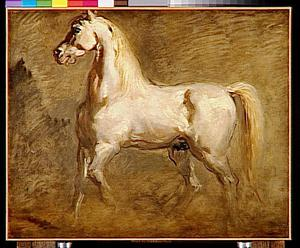
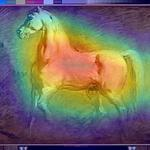
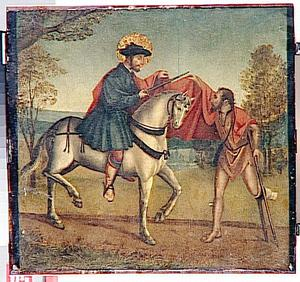
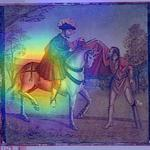
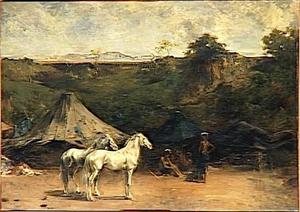
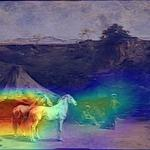
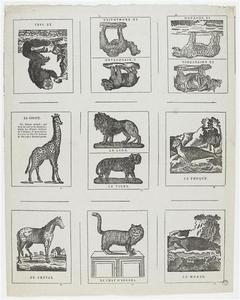
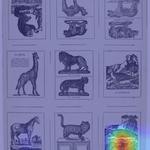
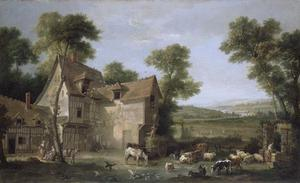
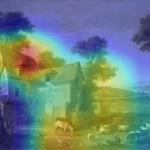
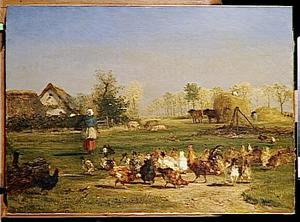
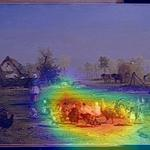

In [20]:
df = pd.DataFrame(columns= ['image', 'crop', 'heatmap','overlay_top1', 'top1', 'overlay'] + [theClass])# + ['repr'])
df.image = [x[0] for x in dataloader.dataset.samples]
df.crop = inputs
df.heatmap = heatmaps
df.overlay_top1 = overlays_top1
df.overlay = overlays
#df.repr = [gather_annotation_target(dataloader.dataset, x) for x in range(len(dataloader.dataset))]

df.top1 = ['%s<br>%.3f' % (classes[torch.sigmoid(p).squeeze().argmax()] ,  torch.sigmoid(p).squeeze().max()) for p in preds]
df[theClass] = ['%s<br>%.3f' % (theClass, torch.sigmoid(p).squeeze() [classes.index(theClass)]) for p in preds]


pd.set_option('display.max_colwidth', None)
pd.set_option('colheader_justify', 'left') 
pd.set_option('display.precision', 3)

df.style.set_table_styles([ dict(selector='th', props=[('text-align', 'center') , 
                                                         ('vertical-align', 'top') ] ) ])
    
df.style.set_properties(**{'text-align': 'left'})

formatters_dict={'image': image_formatter,
                 'crop': image_formatter,
                 'heatmap': image_formatter,
                 'overlay_top1': image_formatter,
                 'overlay': image_formatter,
                 'repr': label_formatter,}


HTML(  #df.sort_values(by=[theClass, 'top1'], ascending=False) [:10] \
      df.loc[:,['image', 'overlay', 'cheval']].to_html( formatters=formatters_dict, 
                        escape=False,
                        index=False)  )  

In [45]:
HTML(  #df.sort_values(by=[theClass, 'top1'], ascending=False) [:10] \
      df.loc[:,['image', 'overlay', 'cheval']].to_html('html\\cheval_multi_CAM_test.html', formatters=formatters_dict, 
                        escape=False,
                        index=False)  )  

<IPython.core.display.HTML object>

## MatplotLib Visualization

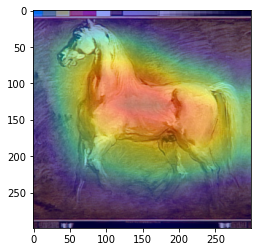

In [16]:
plt.imshow(overlays[0])

<Figure size 432x288 with 0 Axes>

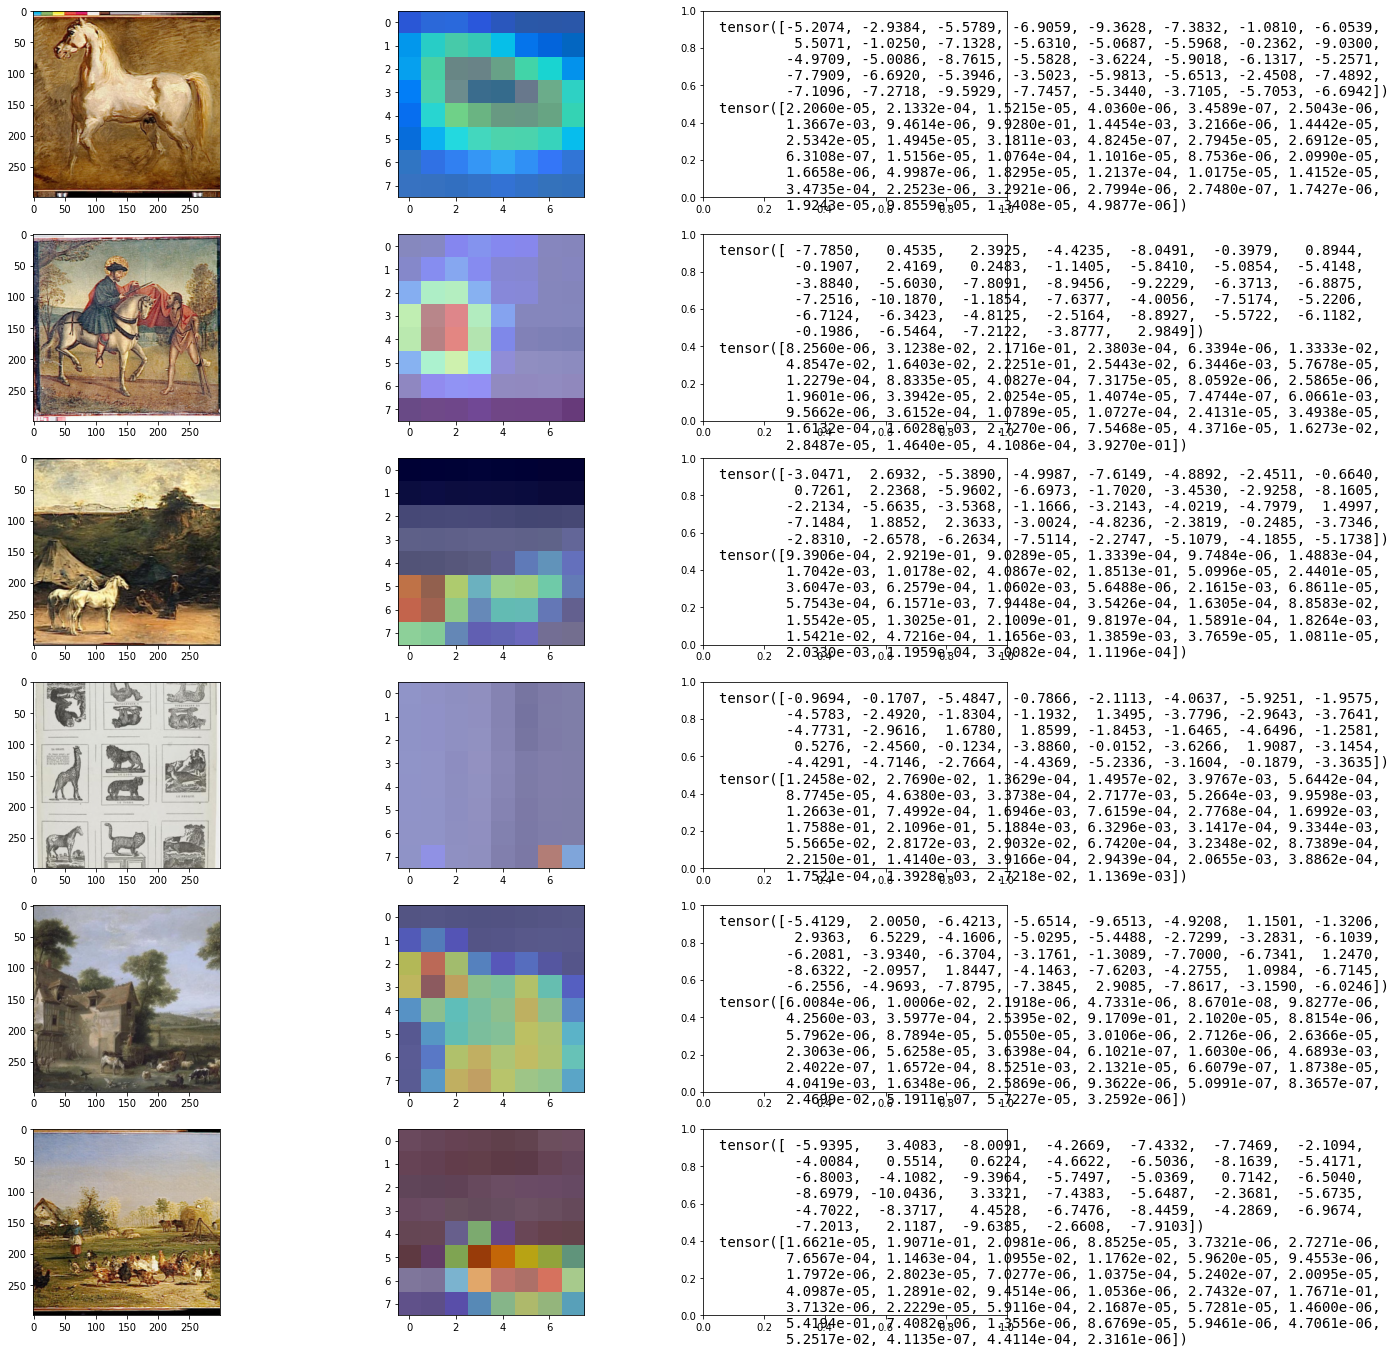

In [19]:
rows=len(dataloader)

plt.tight_layout()
fig, axes = plt.subplots(nrows=rows, ncols=3,  gridspec_kw = {'width_ratios':[1, 1, 1]})
fig.set_size_inches(18.5, 4 * rows)

fontsize=14
fontfamily='monospace'

for i in range(6):
    
    axes[i,0].imshow(inputs[i])
    
    axes[i,1].imshow(inputs[i])
    axes[i,1].imshow(heatmaps[i], alpha = 0.4, cmap='jet')
    
    axes[i, 2].text(0.05, 0.95, str(preds[i].squeeze()) + '\n' +str(torch.softmax(preds[i], dim=1).squeeze()),
                                 
                                    fontsize=fontsize, family=fontfamily, verticalalignment='top',  wrap=True)